In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q evaluate
!pip install -q datasets seqeval transformers accelerate peft bitsandbytes evaluate
!pip install -q --upgrade datasets seqeval transformers accelerate peft bitsandbytes evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires 

In [2]:

from huggingface_hub import notebook_login
notebook_login()


In [3]:
import numpy as np
import evaluate
from datasets import load_dataset, Features, Sequence, Value, Array2D, Array3D
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers.data.data_collator import default_data_collator
from peft import LoraConfig, get_peft_model


2025-05-12 08:10:21.959361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747037422.187216      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747037422.256920      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load the dataset
# this dataset have train, validation, and test splits
dataset = load_dataset("Hyeoli/layoutlmv3_cord")
print(dataset)
print(dataset["train"].features)

# Column definitions
column_names = dataset["train"].column_names
image_col = "image"
words_col = "words"
boxes_col = "bboxes"
labels_col = "ner_tags"

# Prepare label mapping
features_info = dataset["train"].features
if hasattr(features_info[labels_col].feature, 'names'):
    label_list = features_info[labels_col].feature.names
else:
    # fallback for non classlabel
    all_labels = set()
    for lbls in dataset["train"][labels_col]:
        all_labels.update(lbls)
    label_list = sorted(all_labels)

id2label = {i: lbl for i, lbl in enumerate(label_list)}
label2id = {lbl: i for i, lbl in enumerate(label_list)}
num_labels = len(label_list)
print("Labels:", label_list)


README.md:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

(…)-00000-of-00003-9b9c6fecf805041e.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

(…)-00001-of-00003-bd2564ea21985440.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

(…)-00002-of-00003-de31fcc6e3e82029.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

(…)-00000-of-00001-c4023a5d77b0e7dd.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

(…)-00000-of-00001-217fb82c86b5ecc7.parquet:   0%|          | 0.00/162M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 100
    })
})
{'id': Value(dtype='string', id=None), 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'I-menu.cnt', 'I-menu.discountprice', 'I-menu.nm', 'I-menu.num', 'I-menu.price', 'I-menu.sub_cnt', 'I-menu.sub_nm', 'I-menu.sub_price', 'I-menu.unitprice', 'I-sub_total.discount_price', 'I-sub_total.etc', 'I-sub_total.service_price', 'I-sub_total.subtotal_price', 'I-sub_total.tax_price', 'I-total.cashprice', 'I-total.changeprice', 'I-total.cr

In [5]:
# Load processor
processor = AutoProcessor.from_pretrained(
    "microsoft/layoutlmv3-base", apply_ocr=False
)

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [6]:
# Function to prepare examples for the model
def prepare_examples(examples):
    images = examples[image_col]
    words = examples[words_col]
    boxes = examples[boxes_col]
    word_labels = examples[labels_col]
    encoding = processor(
        images,
        words,
        boxes=boxes,
        word_labels=word_labels,
        truncation=True,
        padding="max_length"
    )
    return encoding


In [7]:
# Define new dataset features
new_features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64'))
})

# Map and format each split
train_dataset = dataset['train'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=new_features
)
validation_dataset = dataset['validation'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=new_features
)
test_dataset = dataset['test'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=new_features
)
# Set format to PyTorch tensors
train_dataset.set_format(type="torch")
validation_dataset.set_format(type="torch")
test_dataset.set_format(type="torch")


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [8]:
# Load evaluation metric
metric = evaluate.load("seqeval")

# Compute metrics for trainer
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=2)
    true_preds, true_labels = [], []
    for pred, lab in zip(preds, labels):
        cur_preds, cur_labels = [], []
        for p_id, l_id in zip(pred, lab):
            if l_id != -100:
                cur_preds.append(label_list[p_id])
                cur_labels.append(label_list[l_id])
        true_preds.append(cur_preds)
        true_labels.append(cur_labels)
    results = metric.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

In [9]:
# Configure LoRA for fine tune
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="TOKEN_CLS"
)

In [10]:
# Load base model and apply LoRA
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 903,191 || all params: 126,838,446 || trainable%: 0.7121


In [32]:
# Training arguments 
training_args = TrainingArguments(
    output_dir="LayoutLMv3-LoRA",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_steps=100,
    save_steps=100,
    logging_steps=50,
    learning_rate=2e-4,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="steps",
    eval_strategy="steps",
    report_to="none",
    push_to_hub=True
)

In [33]:
# Initialize Trainer 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/tmp/ipykernel_31/4059246999.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
# Start training
trainer.train()

# Evaluate and print metrics for train, validation, and test splits
print("Train metrics:\n", trainer.evaluate(train_dataset))
print("Validation metrics:\n", trainer.evaluate(validation_dataset))
print("Test metrics:\n", trainer.evaluate(test_dataset))

# Save the fine tuned model and processor
model.save_pretrained(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist

Train metrics:
 {'eval_loss': 0.03389420360326767, 'eval_precision': 0.9883827296011709, 'eval_recall': 0.9879308768400841, 'eval_f1': 0.9881567515661439, 'eval_accuracy': 0.9912235415591121, 'eval_runtime': 30.6046, 'eval_samples_per_second': 26.14, 'eval_steps_per_second': 3.267, 'epoch': 10.0}
Validation metrics:
 {'eval_loss': 0.15123103559017181, 'eval_precision': 0.95, 'eval_recall': 0.9538461538461539, 'eval_f1': 0.951919191919192, 'eval_accuracy': 0.9666056724611162, 'eval_runtime': 3.8373, 'eval_samples_per_second': 26.06, 'eval_steps_per_second': 3.388, 'epoch': 10.0}
Test metrics:
 {'eval_loss': 0.1676798313856125, 'eval_precision': 0.9354838709677419, 'eval_recall': 0.9475683890577508, 'eval_f1': 0.9414873537183842, 'eval_accuracy': 0.9614079728583546, 'eval_runtime': 4.214, 'eval_samples_per_second': 23.731, 'eval_steps_per_second': 3.085, 'epoch': 10.0}


[]

In [20]:
import torch
import numpy as np
from transformers import (
    AutoProcessor,
    LayoutLMv3ForTokenClassification,
    Trainer,
    TrainingArguments
)
from transformers.data.data_collator import default_data_collator


#  load the processor and base model 
processor = AutoProcessor.from_pretrained(
    "microsoft/layoutlmv3-base",
    apply_ocr=False
)
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

#  move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#  set up TrainingArguments for evaluation 
eval_args = TrainingArguments(
    output_dir="tmp_eval_base",     
    per_device_eval_batch_size=4,    
    do_train=False,                  
    do_eval=True,                    
    logging_strategy="steps",       
    logging_steps=50,                
    save_strategy="no",              
    report_to=[],                    
    disable_tqdm=False              
)

#  build the Trainer with eval_dataset 
eval_trainer = Trainer(
    model=model,                             
    args=eval_args,                           
    tokenizer=processor,                      
    data_collator=default_data_collator,      
    compute_metrics=compute_metrics,          
    eval_dataset=test_dataset                
)

#  run evaluation with simple tracing prints 
print(" Starting evaluation ...")
metrics = eval_trainer.evaluate() 
print(" Evaluation completed.")
print(" Results on the base model")
for key, value in metrics.items():
    print(f"{key:>15}: {value:.4f}")


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/2326587426.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


 Starting evaluation ...


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


 Evaluation completed.
 Results on the base model
      eval_loss: 3.2068
eval_model_preparation_time: 0.0028
 eval_precision: 0.0082
    eval_recall: 0.0099
        eval_f1: 0.0089
  eval_accuracy: 0.0305
   eval_runtime: 4.0551
eval_samples_per_second: 24.6600
eval_steps_per_second: 6.1650


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall        f1  accuracy
Baseline          0.008200  0.009900  0.008900  0.030500
LoRA Fine-tuned   0.935484  0.947568  0.941487  0.961408

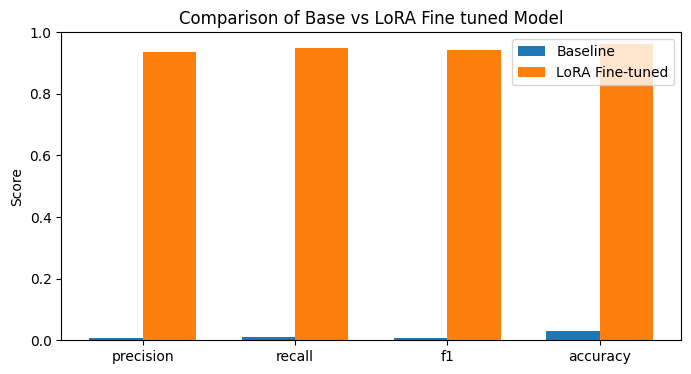

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

baseline_metrics = {
    "precision": 0.0082,
    "recall":    0.0099,
    "f1":        0.0089,
    "accuracy":  0.0305
}
lora_metrics = {
    "precision": 0.9354838709677419,
    "recall":    0.9475683890577508,
    "f1":        0.9414873537183842,
    "accuracy":  0.9614079728583546
}


df = pd.DataFrame([baseline_metrics, lora_metrics],
                  index=["Baseline", "LoRA Fine-tuned"])
display(df)


metrics = df.columns.tolist()
x = range(len(metrics))

plt.figure(figsize=(8, 4))
for i, model_name in enumerate(df.index):
    plt.bar([xi + i*0.35 for xi in x],
            df.loc[model_name],
            width=0.35,
            label=model_name)
plt.xticks([xi + 0.35/2 for xi in x], metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Comparison of Base vs LoRA Fine tuned Model")
plt.legend()
plt.show()


In [9]:
from transformers import LayoutLMv3ForTokenClassification
from peft import PeftModel
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load base model
base_model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

# overlay  LoRA adapters from the saved checkpoint
model = PeftModel.from_pretrained(
    base_model,
    "/kaggle/input/nlu-lora-checkpoint-2000"
).to(device)

model.eval()


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): LayoutLMv3ForTokenClassification(
      (layoutlmv3): LayoutLMv3Model(
        (embeddings): LayoutLMv3TextEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (x_position_embeddings): Embedding(1024, 128)
          (y_position_embeddings): Embedding(1024, 128)
          (h_position_embeddings): Embedding(1024, 128)
          (w_position_embeddings): Embedding(1024, 128)
        )
        (patch_embed): LayoutLMv3PatchEmbeddings(
          (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


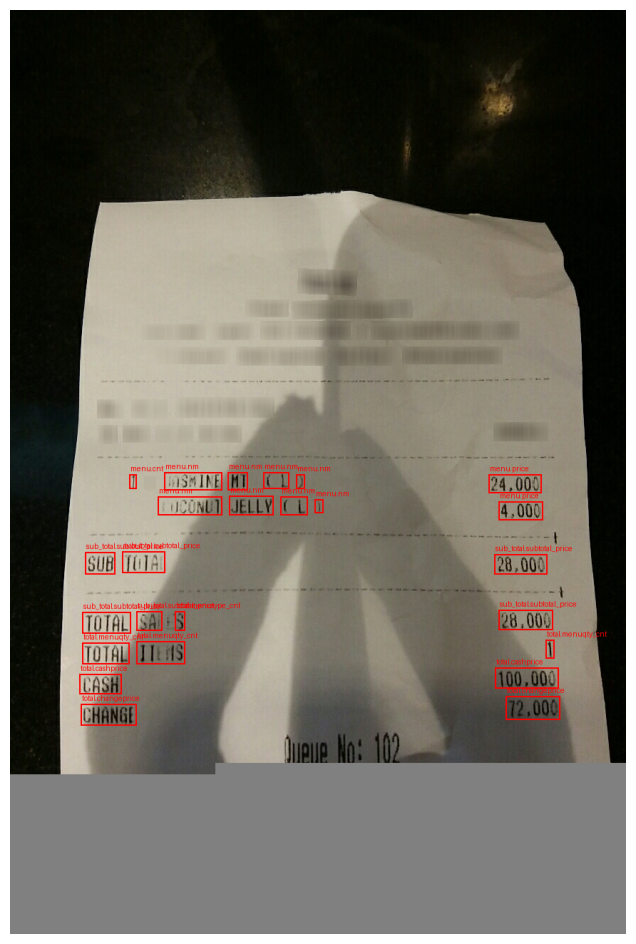

In [10]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
import torch
import os


def unnormalize_box(box, width, height):
    """
    Convert LayoutLMv3-style box coordinates (0–1000) into pixel coordinates.
    """
    x0, y0, x1, y1 = box
    return [
        int(x0 / 1000 * width),
        int(y0 / 1000 * height),
        int(x1 / 1000 * width),
        int(y1 / 1000 * height),
    ]

def iob_to_label(iob_label):
    """
    Strip off the IOB prefix (B-, I-) to get the bare entity label.
    """
    return iob_label.split('-', 1)[-1] if '-' in iob_label else iob_label


label_color = "red"

#  Load a font
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size=24)
except Exception:
    font = ImageFont.load_default()

#  Select the  sample
sample = dataset['test'][2]
img = sample['image'].convert("RGB")
width, height = img.size

# Run inference 
encoding = processor(
    sample['image'],
    sample['words'],
    boxes=sample['bboxes'],
    truncation=True,
    padding="max_length",
    return_tensors="pt"
).to(model.device)

with torch.no_grad():
    outputs = model(**encoding)
    pred_ids = outputs.logits.argmax(dim=2).squeeze().cpu().tolist()

#  Draw boxes & labels using word_ids mapping 
draw = ImageDraw.Draw(img)
word_ids = encoding.word_ids(batch_index=0)
seen = set()

for tok_idx, word_idx in enumerate(word_ids):
    if word_idx is None or word_idx in seen:
        continue
    seen.add(word_idx)

    # Get the predicted label for this token
    raw_label = id2label[pred_ids[tok_idx]]    
    label     = iob_to_label(raw_label)        
    box       = sample['bboxes'][word_idx]
    box_px    = unnormalize_box(box, width, height)

    # Draw rectangle and text
    draw.rectangle(box_px, outline=label_color, width=2)
    text_x = box_px[0] + 2
    text_y = box_px[1] - (font.size + 4)
    draw.text((text_x, text_y), label, fill=label_color, font=font)

#  Display the annotated image
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()


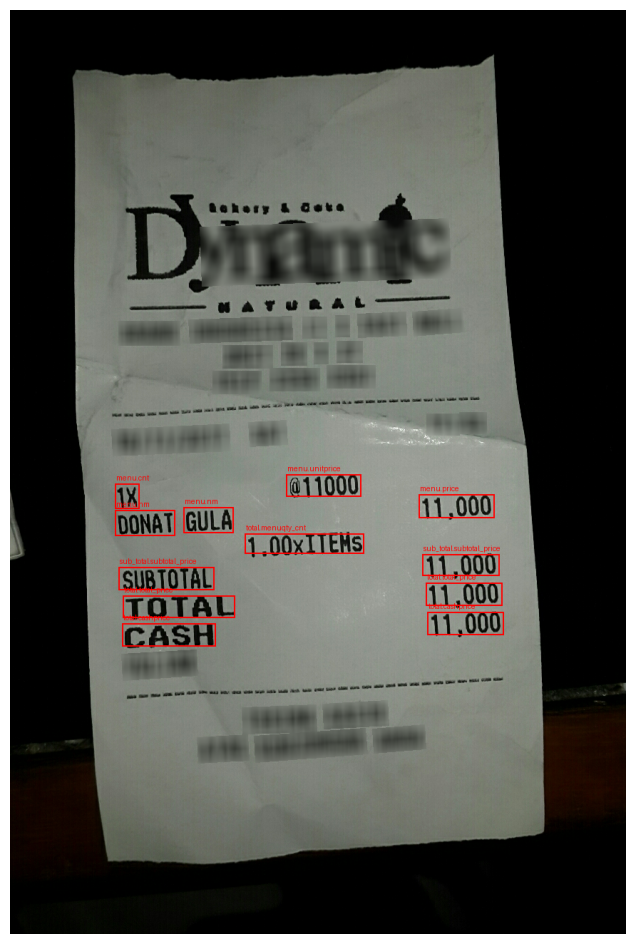

In [45]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
import torch

# ─── Load a font
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size=24)
except Exception:
    font = ImageFont.load_default()

# ─── Process sample 
sample = dataset['test'][3]
img = sample['image'].convert("RGB")
width, height = img.size

encoding = processor(
    sample['image'],
    sample['words'],
    boxes=sample['bboxes'],
    truncation=True,
    padding="max_length",
    return_tensors="pt"
).to(model.device)

with torch.no_grad():
    outputs = model(**encoding)
    pred_ids = outputs.logits.argmax(dim=2).squeeze().cpu().tolist()

# Draw boxes & labels
draw = ImageDraw.Draw(img)
word_ids = encoding.word_ids(batch_index=0)
seen = set()

for tok_idx, word_idx in enumerate(word_ids):
    if word_idx is None or word_idx in seen:
        continue
    seen.add(word_idx)

    raw_label = id2label[pred_ids[tok_idx]]
    label     = iob_to_label(raw_label)
    box       = sample['bboxes'][word_idx]
    box_px    = unnormalize_box(box, width, height)

    draw.rectangle(box_px, outline="red", width=2)
    text_x = box_px[0] + 2
    text_y = box_px[1] - (font.size + 4)
    draw.text((text_x, text_y), label, fill="red", font=font)

# Display the result 
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()


In [42]:
import pandas as pd
import torch

device = next(model.parameters()).device
model.eval()

results = []
for i in range(10):
    sample = dataset["test"][i]
    encoding = processor(
        sample["image"].convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        logits = model(**encoding).logits
    
    pred_ids = logits.argmax(dim=-1).squeeze().cpu().tolist()
    word_ids = encoding.word_ids(batch_index=0)
    
    wrds, trues, preds = [], [], []
    seen = set()
    for tok_idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen:
            continue
        seen.add(word_idx)
        wrds.append(sample["words"][word_idx])
        trues.append(id2label[sample["ner_tags"][word_idx]])
        preds.append(id2label[pred_ids[tok_idx]])
    
    df = pd.DataFrame({
        "sample_idx": i,
        "word": wrds,
        "true_label": trues,
        "pred_label": preds
    })
    results.append(df)

comparison_df = pd.concat(results, ignore_index=True)
print(comparison_df)


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


     sample_idx                word             true_label  \
0             0                 TAX  I-sub_total.tax_price   
1             0               5.455  I-sub_total.tax_price   
2             0               TOTAL    I-total.total_price   
3             0              60.000    I-total.total_price   
4             0                (Qty    I-total.menuqty_cnt   
..          ...                 ...                    ...   
181           9           Kembalian    I-total.changeprice   
182           9               14000    I-total.changeprice   
183           9  Bumbu Kaldu Ayam 1              I-menu.nm   
184           9               36000       I-menu.unitprice   
185           9               36000           I-menu.price   

                pred_label  
0    I-sub_total.tax_price  
1    I-sub_total.tax_price  
2      I-total.total_price  
3      I-total.total_price  
4      I-total.menuqty_cnt  
..                     ...  
181    I-total.changeprice  
182    I-total.changepr

In [43]:
comparison_df.head(10)

sample_idx    word               true_label               pred_label
0           0     TAX    I-sub_total.tax_price    I-sub_total.tax_price
1           0   5.455    I-sub_total.tax_price    I-sub_total.tax_price
2           0   TOTAL      I-total.total_price      I-total.total_price
3           0  60.000      I-total.total_price      I-total.total_price
4           0    (Qty      I-total.menuqty_cnt      I-total.menuqty_cnt
5           0    2.00      I-total.menuqty_cnt      I-total.menuqty_cnt
6           0     EDC  I-total.creditcardprice  I-total.creditcardprice
7           0    CIMB  I-total.creditcardprice  I-total.creditcardprice
8           0   NIAGA  I-total.creditcardprice  I-total.creditcardprice
9           0     No:  I-total.creditcardprice  I-total.creditcardprice

In [48]:
import shutil

checkpoint_dir = "LayoutLMv3-LoRA/checkpoint-2000"
shutil.make_archive("checkpoint-2000", 'zip', checkpoint_dir)

print("Created checkpoint-2000.zip")


Created checkpoint-2000.zip


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


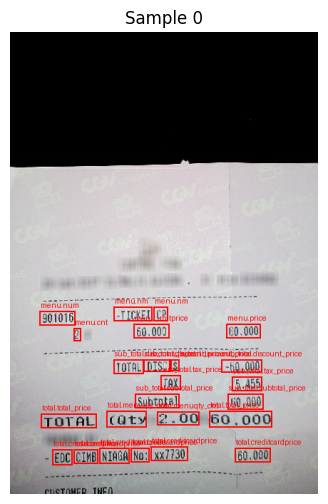

word                  true_label                  pred_label
0        TAX       I-sub_total.tax_price       I-sub_total.tax_price
1      5.455       I-sub_total.tax_price       I-sub_total.tax_price
2      TOTAL         I-total.total_price         I-total.total_price
3     60.000         I-total.total_price         I-total.total_price
4       (Qty         I-total.menuqty_cnt         I-total.menuqty_cnt
5       2.00         I-total.menuqty_cnt         I-total.menuqty_cnt
6        EDC     I-total.creditcardprice     I-total.creditcardprice
7       CIMB     I-total.creditcardprice     I-total.creditcardprice
8      NIAGA     I-total.creditcardprice     I-total.creditcardprice
9        No:     I-total.creditcardprice     I-total.creditcardprice
10    xx7730     I-total.creditcardprice     I-total.creditcardprice
11    60.000     I-total.creditcardprice     I-total.creditcardprice
12    901016                  I-menu.num                  I-menu.num
13   -TICKET                   I-menu.nm                   I-menu.nm
14        CP                   I-menu.nm                   I-menu.nm
15         2                  I-menu.cnt                  I-menu.cnt
16    60.000                I-menu.price            I-menu.unitprice
17    60.000                           O                I-menu.price
18  Subtotal  I-sub_total.subtotal_price  I-sub_total.subtotal_price
19    60.000  I-sub_total.subtotal_price  I-sub_total.subtotal_price
20     TOTAL  I-sub_total.discount_price  I-sub_total.discount_price
21      DISC  I-sub_total.discount_price  I-sub_total.discount_price
22         $  I-sub_total.discount_price  I-sub_total.discount_price
23   -60.000  I-sub_total.discount_price  I-sub_total.discount_price

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


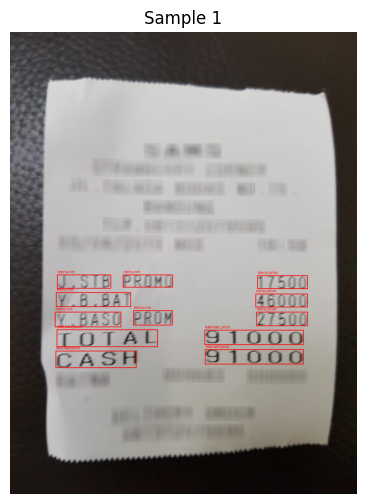

word           true_label           pred_label
0     J.STB            I-menu.nm            I-menu.nm
1     PROMO            I-menu.nm            I-menu.nm
2     17500         I-menu.price         I-menu.price
3   Y.B.BAT            I-menu.nm            I-menu.nm
4     46000         I-menu.price         I-menu.price
5    Y.BASO            I-menu.nm            I-menu.nm
6      PROM            I-menu.nm            I-menu.nm
7     27500         I-menu.price         I-menu.price
8     TOTAL  I-total.total_price  I-total.total_price
9     91000  I-total.total_price  I-total.total_price
10     CASH    I-total.cashprice    I-total.cashprice
11    91000    I-total.cashprice    I-total.cashprice

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


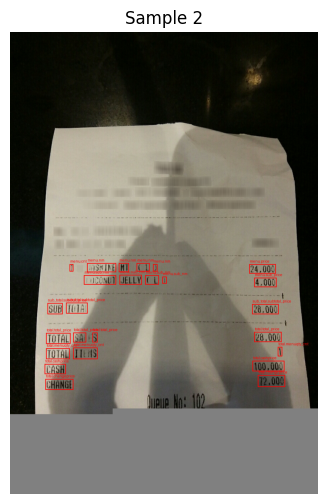

word                  true_label                  pred_label
0         1                  I-menu.cnt                  I-menu.cnt
1   JASMINE                   I-menu.nm                   I-menu.nm
2        MT                   I-menu.nm                   I-menu.nm
3       ( L                   I-menu.nm                   I-menu.nm
4         )                   I-menu.nm                   I-menu.nm
5    24,000                I-menu.price                I-menu.price
6   COCONUT               I-menu.sub_nm               I-menu.sub_nm
7     JELLY               I-menu.sub_nm               I-menu.sub_nm
8       ( L               I-menu.sub_nm               I-menu.sub_nm
9         )               I-menu.sub_nm               I-menu.sub_nm
10    4,000            I-menu.sub_price            I-menu.sub_price
11      SUB  I-sub_total.subtotal_price  I-sub_total.subtotal_price
12    TOTAL  I-sub_total.subtotal_price  I-sub_total.subtotal_price
13   28,000  I-sub_total.subtotal_price  I-sub_total.subtotal_price
14    TOTAL         I-total.total_price         I-total.total_price
15      SAI         I-total.total_price         I-total.total_price
16        S         I-total.total_price         I-total.total_price
17   28,000         I-total.total_price         I-total.total_price
18    TOTAL         I-total.menuqty_cnt         I-total.menuqty_cnt
19    ITEMS         I-total.menuqty_cnt         I-total.menuqty_cnt
20        1         I-total.menuqty_cnt         I-total.menuqty_cnt
21     CASH           I-total.cashprice           I-total.cashprice
22  100,000           I-total.cashprice           I-total.cashprice
23   CHANGE         I-total.changeprice         I-total.changeprice
24   72,000         I-total.changeprice         I-total.changeprice

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


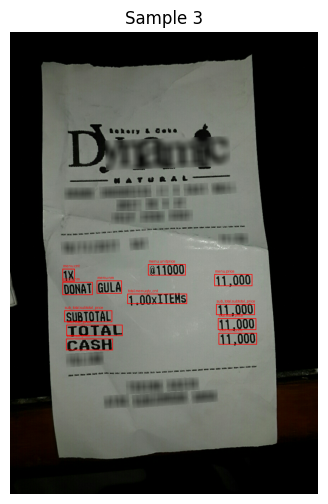

word                  true_label                  pred_label
0           1X                  I-menu.cnt                  I-menu.cnt
1       @11000            I-menu.unitprice            I-menu.unitprice
2        DONAT                   I-menu.nm                   I-menu.nm
3         GULA                   I-menu.nm                   I-menu.nm
4       11,000                I-menu.price                I-menu.price
5     SUBTOTAL  I-sub_total.subtotal_price  I-sub_total.subtotal_price
6       11,000  I-sub_total.subtotal_price  I-sub_total.subtotal_price
7   1.00xITEMs         I-total.menuqty_cnt         I-total.menuqty_cnt
8        TOTAL         I-total.total_price         I-total.total_price
9       11,000         I-total.total_price         I-total.total_price
10        CASH           I-total.cashprice           I-total.cashprice
11      11,000           I-total.cashprice           I-total.cashprice

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


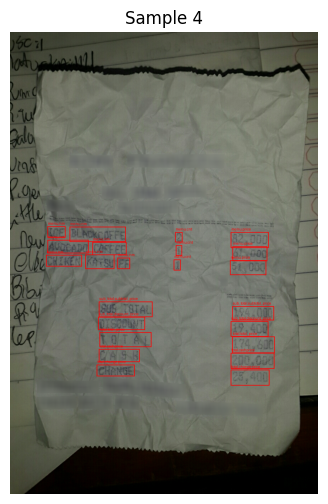

word                  true_label                  pred_label
0          ICE                   I-menu.nm                   I-menu.nm
1   BLACKCOFFE                   I-menu.nm                   I-menu.nm
2            2                  I-menu.cnt                  I-menu.cnt
3       82,000                I-menu.price                I-menu.price
4        TOTAL         I-total.total_price         I-total.total_price
5      174,600         I-total.total_price         I-total.total_price
6         CASH           I-total.cashprice           I-total.cashprice
7      200,000           I-total.cashprice           I-total.cashprice
8       CHANGE         I-total.changeprice         I-total.changeprice
9       25,400         I-total.changeprice         I-total.changeprice
10     AVOCADO                   I-menu.nm                   I-menu.nm
11      COFFEE                   I-menu.nm                   I-menu.nm
12           1                  I-menu.cnt                  I-menu.cnt
13      61,000                I-menu.price                I-menu.price
14      CHIKEN                   I-menu.nm                   I-menu.nm
15       KATSU                   I-menu.nm                   I-menu.nm
16          FF                   I-menu.nm                   I-menu.nm
17           1                  I-menu.cnt                  I-menu.cnt
18      51,000                I-menu.price                I-menu.price
19   SUB_TOTAL  I-sub_total.subtotal_price  I-sub_total.subtotal_price
20     194,000  I-sub_total.subtotal_price  I-sub_total.subtotal_price
21    DISCOUNT  I-sub_total.discount_price  I-sub_total.discount_price
22      19,400  I-sub_total.discount_price  I-sub_total.discount_price

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


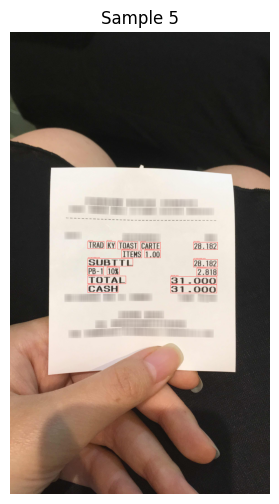

word                  true_label                  pred_label
0     TRAD                   I-menu.nm                   I-menu.nm
1       KY                   I-menu.nm                   I-menu.nm
2    TOAST                   I-menu.nm                   I-menu.nm
3    CARTE                   I-menu.nm                   I-menu.nm
4   28.182                I-menu.price                I-menu.price
5   SUBTTL  I-sub_total.subtotal_price  I-sub_total.subtotal_price
6   28.182  I-sub_total.subtotal_price  I-sub_total.subtotal_price
7     PB-1       I-sub_total.tax_price       I-sub_total.tax_price
8      10%       I-sub_total.tax_price       I-sub_total.tax_price
9    2.818       I-sub_total.tax_price       I-sub_total.tax_price
10   TOTAL         I-total.total_price         I-total.total_price
11  31.000         I-total.total_price         I-total.total_price
12    CASH           I-total.cashprice           I-total.cashprice
13  31.000           I-total.cashprice           I-total.cashprice
14   ITEMS         I-total.menuqty_cnt         I-total.menuqty_cnt
15    1.00         I-total.menuqty_cnt         I-total.menuqty_cnt

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


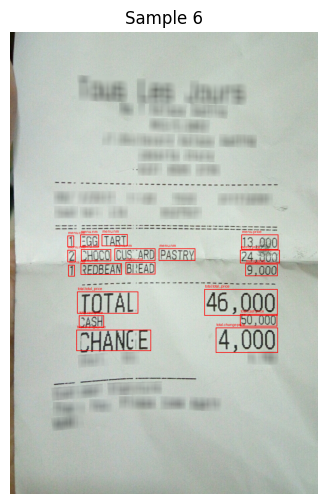

word           true_label           pred_label
0         1           I-menu.cnt           I-menu.cnt
1       EGG            I-menu.nm            I-menu.nm
2      TART            I-menu.nm            I-menu.nm
3    13,000         I-menu.price         I-menu.price
4         2           I-menu.cnt           I-menu.cnt
5     CHOCO            I-menu.nm            I-menu.nm
6   CUS ARD            I-menu.nm            I-menu.nm
7    PASTRY            I-menu.nm            I-menu.nm
8    24,000         I-menu.price         I-menu.price
9         1           I-menu.cnt           I-menu.cnt
10  REDBEAN            I-menu.nm            I-menu.nm
11    BREAD            I-menu.nm            I-menu.nm
12    9,000         I-menu.price         I-menu.price
13    TOTAL  I-total.total_price  I-total.total_price
14   46,000  I-total.total_price  I-total.total_price
15     CASH    I-total.cashprice    I-total.cashprice
16   50,000    I-total.cashprice    I-total.cashprice
17   CHANGE  I-total.changeprice  I-total.changeprice
18    4,000  I-total.changeprice  I-total.changeprice

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


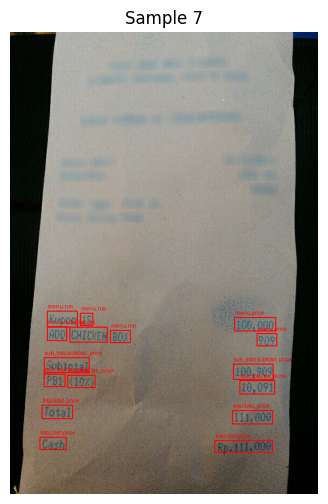

word                  true_label                  pred_label
0         Kupon                   I-menu.nm                   I-menu.nm
1            15                   I-menu.nm                   I-menu.nm
2       100,000                I-menu.price                I-menu.price
3           ADD               I-menu.sub_nm               I-menu.sub_nm
4       CHICKEN               I-menu.sub_nm                   I-menu.nm
5           BOX               I-menu.sub_nm                   I-menu.nm
6           909            I-menu.sub_price                I-menu.price
7      Subtotal  I-sub_total.subtotal_price  I-sub_total.subtotal_price
8       100,909  I-sub_total.subtotal_price  I-sub_total.subtotal_price
9           PB1       I-sub_total.tax_price       I-sub_total.tax_price
10        (10%)       I-sub_total.tax_price       I-sub_total.tax_price
11       10,091       I-sub_total.tax_price       I-sub_total.tax_price
12        Total         I-total.total_price         I-total.total_price
13      111,000         I-total.total_price         I-total.total_price
14         Cash           I-total.cashprice           I-total.cashprice
15  Rp. 111,000           I-total.cashprice           I-total.cashprice

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


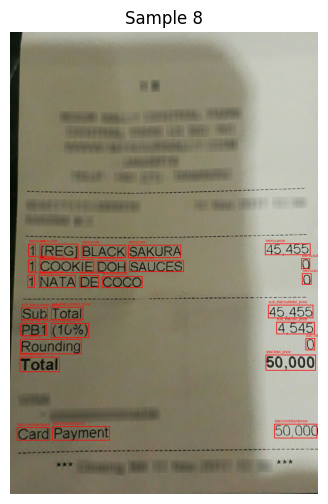

word                  true_label                  pred_label
0          1                  I-menu.cnt                  I-menu.cnt
1      [REG]                   I-menu.nm                   I-menu.nm
2      BLACK                   I-menu.nm                   I-menu.nm
3     SAKURA                   I-menu.nm                   I-menu.nm
4     45,455                I-menu.price                I-menu.price
5          1              I-menu.sub_cnt              I-menu.sub_cnt
6     COOKIE               I-menu.sub_nm               I-menu.sub_nm
7        DOH               I-menu.sub_nm               I-menu.sub_nm
8     SAUCES               I-menu.sub_nm               I-menu.sub_nm
9          0            I-menu.sub_price            I-menu.sub_price
10         1              I-menu.sub_cnt              I-menu.sub_cnt
11      NATA               I-menu.sub_nm               I-menu.sub_nm
12        DE               I-menu.sub_nm               I-menu.sub_nm
13      COCO               I-menu.sub_nm               I-menu.sub_nm
14         0            I-menu.sub_price            I-menu.sub_price
15       Sub  I-sub_total.subtotal_price  I-sub_total.subtotal_price
16     Total  I-sub_total.subtotal_price  I-sub_total.subtotal_price
17    45,455  I-sub_total.subtotal_price  I-sub_total.subtotal_price
18       PB1       I-sub_total.tax_price       I-sub_total.tax_price
19     (10%)       I-sub_total.tax_price       I-sub_total.tax_price
20     4,545       I-sub_total.tax_price       I-sub_total.tax_price
21  Rounding             I-sub_total.etc             I-sub_total.etc
22         0             I-sub_total.etc             I-sub_total.etc
23     Total         I-total.total_price         I-total.total_price
24    50,000         I-total.total_price         I-total.total_price
25      Card     I-total.creditcardprice     I-total.creditcardprice
26   Payment     I-total.creditcardprice     I-total.creditcardprice
27    50,000     I-total.creditcardprice     I-total.creditcardprice

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


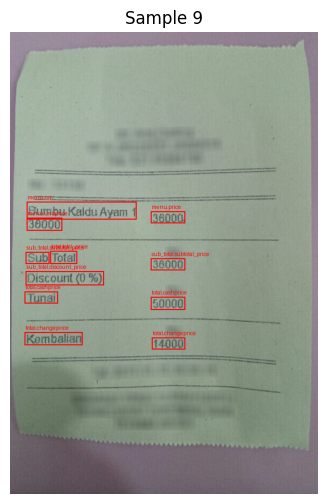

word                  true_label                  pred_label
0                  Sub  I-sub_total.subtotal_price  I-sub_total.subtotal_price
1                Total  I-sub_total.subtotal_price         I-total.total_price
2                36000  I-sub_total.subtotal_price  I-sub_total.subtotal_price
3        Discount (0%)  I-sub_total.discount_price  I-sub_total.discount_price
4                Tunai           I-total.cashprice           I-total.cashprice
5                50000           I-total.cashprice           I-total.cashprice
6            Kembalian         I-total.changeprice         I-total.changeprice
7                14000         I-total.changeprice         I-total.changeprice
8   Bumbu Kaldu Ayam 1                   I-menu.nm                   I-menu.nm
9                36000            I-menu.unitprice            I-menu.unitprice
10               36000                I-menu.price                I-menu.price

In [39]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageDraw, ImageFont
from transformers import AutoProcessor

def unnormalize_box(box, width, height):
    x0, y0, x1, y1 = box
    return [
        int(x0 / 1000 * width),
        int(y0 / 1000 * height),
        int(x1 / 1000 * width),
        int(y1 / 1000 * height),
    ]

def iob_to_label(iob_label):
    return iob_label.split('-', 1)[-1] if '-' in iob_label else iob_label

# loading font
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size=20)
except Exception:
    font = ImageFont.load_default()

device = next(model.parameters()).device
model.eval()
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

for i in range(10):
    sample = dataset["test"][i]
    image = sample["image"].convert("RGB")
    width, height = image.size

    encoding = processor(
        image,
        sample["words"],
        boxes=sample["bboxes"],
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        logits = model(**encoding).logits
    pred_ids = logits.argmax(dim=-1).squeeze().cpu().tolist()

    draw = ImageDraw.Draw(image)
    word_ids = encoding.word_ids(batch_index=0)
    seen = set()
    for tok_idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen:
            continue
        seen.add(word_idx)

        
        raw_label = id2label[pred_ids[tok_idx]]    
        label     = iob_to_label(raw_label)        
        
        box       = sample["bboxes"][word_idx]
        box_px    = unnormalize_box(box, width, height)

        draw.rectangle(box_px, outline="red", width=2)
        text_x = box_px[0] + 2
        text_y = box_px[1] - (font.size + 4)
        draw.text((text_x, text_y), label, fill="red", font=font)

    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Sample {i}")
    plt.show()

    
    words, trues, preds = [], [], []
    seen = set()
    for tok_idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen:
            continue
        seen.add(word_idx)
        words.append(sample["words"][word_idx])
        trues.append(id2label[sample["ner_tags"][word_idx]])
        preds.append(id2label[pred_ids[tok_idx]])
    df = pd.DataFrame({
        "word": words,
        "true_label": trues,
        "pred_label": preds
    })
    display(df)
